In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Concatenate, Input

In [ ]:
mg = Sequential()

mg.add(Input(shape=(4,84,84)))
mg.add(Conv2D(32, (8,8), strides=(4,4), activation="relu"))
mg.add(Conv2D(64, (4,4), strides=(2,2), activation="relu"))
mg.add(Conv2D(64, (3,3), strides=(1,1), activation="relu"))

mg.add(Flatten())


In [ ]:
mg.summary()

In [ ]:
ml = Sequential()

ml.add(Input(shape=(11,11,1)))
ml.add(Conv2D(128, (11,11)))
ml.add(Flatten())

In [ ]:
ml.summary()

In [ ]:
x = Concatenate(axis=1)([ml.output, mg.output])
model = Sequential()
model.add(Input(shape=x.shape))

model.add(Dense(256, activation="relu"))
model.add(Dense(242, activation="softmax"))

In [ ]:
model.summary()

In [ ]:
x.shape

In [ ]:
ml.output_shape[1] + mg.output_shape[1]

In [ ]:
import numpy as np
np.add(ml.output_shape, mg.output_shape)

In [ ]:
model.compile(optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
from tensorflow import keras
logdir="aaa" 
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Concatenate, Input

class DoodleSDQModel(Model):
    def __init__(self, global_input_size, local_input_size, output_size):
        super(DoodleSDQModel, self).__init__()
        self.global_input_size = global_input_size
        self.local_input_size = local_input_size
        self.output_size = output_size

        self.model_global = self._create_global_CNN()
        self.model_local = self._create_local_CNN()
        self.dense = self._create_dense()

    def _create_global_CNN(self):
        model = Sequential()
        model.add(Input(shape=self.global_input_size))
        model.add(Conv2D(32, (8,8), strides=(4,4), activation="relu"))
        model.add(Conv2D(64, (4,4), strides=(2,2), activation="relu"))
        model.add(Conv2D(64, (3,3), strides=(1,1), activation="relu"))
        return model

    def _create_local_CNN(self):
        model = Sequential()
        model.add(Input(shape=self.local_input_size))
        model.add(Conv2D(128, (11,11), activation="relu"))
        return model

    def _create_dense(self):
        input_shape = (None, self.model_global.output_shape[1] + self.model_local.output_shape[1])
        model = Sequential()
        model.add(Input(shape=input_shape))
        model.add(Dense(256, activation="relu"))
        model.add(Dense(self.output_size, activation="softmax"))
        return model

    def call(self, inputs, patches):
        print("call")
        global_input = inputs
        local_input = patches
        global_features = self.model_global(global_input)
        local_features = self.model_local(local_input)
        
        x = Concatenate(axis=1)([global_features, local_features])
        y_pred = self.dense(x)
        
        return y_pred


In [ ]:
import matplotlib.pyplot as plt

In [12]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Concatenate, Input, MaxPool2D, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

class DoodleSDQModel():
    def __init__(self, global_input_size, local_input_size, output_size):
        #super(DoodleSDQModel, self).__init__()
        self.global_input_size = global_input_size
        self.local_input_size = local_input_size
        self.output_size = output_size
        
        self.model = self._create_model()
        
    def _create_model(self):
        local_input = tf.keras.Input(shape=self.local_input_size)
        global_input = tf.keras.Input(shape=self.global_input_size)
        
        inputs = [global_input, local_input]
        
        x_local = self._create_local_CNN(local_input)
        x_global = self._create_global_CNN(global_input)
        
        x = Concatenate(axis=1)([x_global, x_local])
        
        x = Dense(512)(x)
        x = Activation("relu")(x)
        x = Dense(self.output_size)(x)
        outputs = Activation("softmax") (x)
        return Model(inputs, outputs, name="doodle_dqn")

    def _create_global_CNN(self, input):
        
        x = Conv2D(32, (8,8), strides=(4,4), padding='same')(input)
        x = Activation("relu")(x)
        
        x = Conv2D(64, (4,4), strides=(2,2), padding='same')(x)
        x = Activation("relu")(x)
        
        x = Conv2D(64, (3,3), strides=(1,1), padding='same')(x)
        x = Activation("relu")(x)
        
        x = Flatten()(x)
        x = Dropout(0.5)(x)
        
        return x

    def _create_local_CNN(self, input):
        x = Conv2D(128, (11,11), padding='same')(input)
        x = Activation("relu")(x)
        
        x = Flatten()(x)
        x = Dropout(0.5)(x)
        return x
    
    def train(self,training_gen, validation_data, epochs):
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)
        early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)
        self.epochs = epochs
        self.model.compile(optimizer=Adam(lr=.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        self.history = self.model.fit(training_gen,\
                                      validation_data=validation_data, \
                                      validation_steps= len(validation_data),\
                                      epochs=epochs, \
#                                       callbacks=[reduce_lr], \
                                      verbose=1)
    
    def plot(self):
        acc = self.history.history['accuracy']
        val_acc = self.history.history['val_accuracy']

        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']

        epochs_range = range(self.epochs)

        plt.figure(figsize=(8, 8))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.show()
#     def _create_dense(self):
#         input_shape = (None, self.model_global.output_shape[1] + self.model_local.output_shape[1])
#         model = Sequential()
#         model.add(Input(shape=input_shape))
#         model.add(Dense(256, activation="relu"))
#         model.add(Dense(self.output_size, activation="softmax"))
#         return model

#     def call(self, inputs, patches):
#         print("call")
#         global_input = inputs
#         local_input = patches
#         global_features = self.model_global(global_input)
#         local_features = self.model_local(local_input)
        
#         x = Concatenate(axis=1)([global_features, local_features])
#         y_pred = self.dense(x)
        
#         return y_pred


In [1]:
from random_stroke_generator import RandomStrokeGenerator

In [17]:
training_gen = RandomStrokeGenerator(batch_size=484,num_data=4840, max_strokes=32)
valid_gen = RandomStrokeGenerator(batch_size=242, num_data=484, max_strokes=32)

Length || X : 4840 | Patch : 4840 | y : 4840
Length || X : 484 | Patch : 484 | y : 484


In [18]:
global_size = (84,84,4)
local_size = (11,11,2)
model1 = DoodleSDQModel(global_input_size=global_size, local_input_size=local_size, output_size=242)


In [19]:
model1.model.summary()

Model: "doodle_dqn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 84, 84, 4)]  0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 21, 21, 32)   8224        input_8[0][0]                    
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 21, 21, 32)   0           conv2d_13[0][0]                  
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 11, 11, 64)   32832       activation_19[0][0]              
_________________________________________________________________________________________

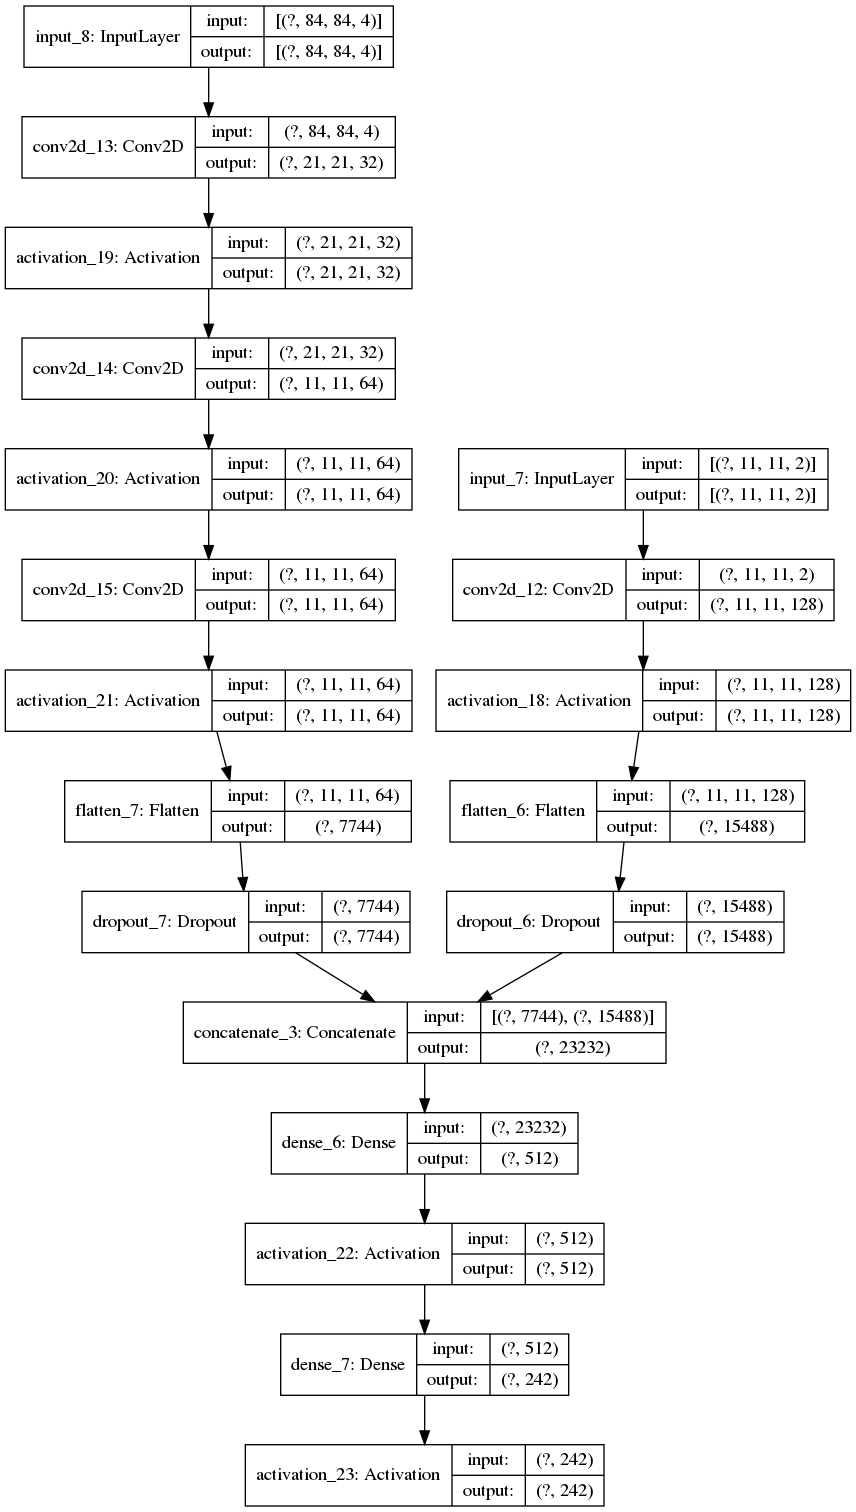

In [20]:
from tensorflow import keras

keras.utils.plot_model(model1.model, "doodle_sdq.png", show_shapes=True)

In [21]:
model1.train(training_gen, valid_gen, 50)

Epoch 1/50
10/10 [==============================] - 1s 51ms/step - loss: 5.4776 - accuracy: 0.0097 - val_loss: 5.4608 - val_accuracy: 0.0207
Epoch 2/50
10/10 [==============================] - 0s 43ms/step - loss: 5.2041 - accuracy: 0.0643 - val_loss: 5.3325 - val_accuracy: 0.0537
Epoch 3/50
10/10 [==============================] - 0s 43ms/step - loss: 4.6997 - accuracy: 0.1333 - val_loss: 5.0514 - val_accuracy: 0.0888
Epoch 4/50
10/10 [==============================] - 0s 40ms/step - loss: 4.0165 - accuracy: 0.2155 - val_loss: 4.9027 - val_accuracy: 0.0930
Epoch 5/50
10/10 [==============================] - 0s 42ms/step - loss: 3.3365 - accuracy: 0.3176 - val_loss: 4.6794 - val_accuracy: 0.1219
Epoch 6/50
10/10 [==============================] - 0s 41ms/step - loss: 2.7215 - accuracy: 0.4211 - val_loss: 4.9399 - val_accuracy: 0.1033
Epoch 7/50
10/10 [==============================] - 0s 41ms/step - loss: 2.2221 - accuracy: 0.4981 - val_loss: 5.1188 - val_accuracy: 0.1136
Epoch 8/50
10

In [24]:
X, y = training_gen.__getitem__(1)

In [ ]:
for layer in model1.model.layers:
    print(layer.name ,layer.trainable)

In [9]:
pred = model1.model(X)

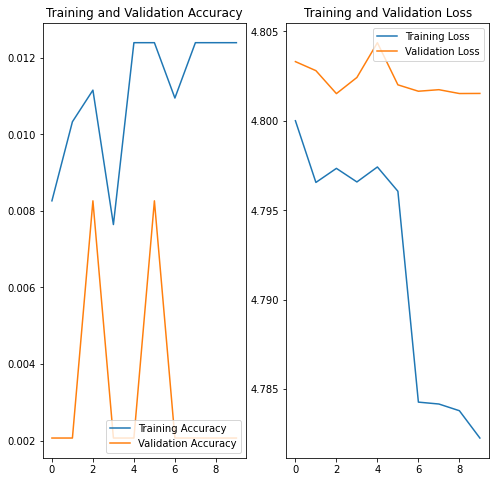

In [25]:
model1.plot()

In [10]:
print(pred[0])

tf.Tensor(
[7.57338137e-10 0.00000000e+00 2.48368838e-25 2.75570002e-08
 2.47874077e-08 9.26043020e-10 0.00000000e+00 4.69784100e-05
 2.51696920e-15 1.22555894e-05 2.98237985e-08 2.43934861e-04
 1.80948730e-35 2.29134131e-38 2.03908110e-38 3.16995003e-36
 8.72169351e-11 5.62039720e-11 0.00000000e+00 1.33587514e-08
 8.08693343e-08 2.30046966e-21 5.25476790e-37 3.29601266e-06
 4.67168550e-32 0.00000000e+00 1.42177907e-35 3.65629224e-30
 2.04743724e-15 2.34232012e-09 2.64589114e-32 2.22104113e-10
 3.37220898e-12 6.68373888e-18 6.81258098e-05 1.14344681e-36
 1.89206411e-19 1.45335541e-33 1.47926656e-07 2.04850409e-07
 2.18285368e-09 1.79558878e-22 1.01851808e-11 6.37849098e-08
 6.49240431e-17 1.08109859e-08 2.97242593e-07 3.92393395e-06
 4.80400537e-08 6.23088781e-08 0.00000000e+00 1.44005163e-08
 0.00000000e+00 6.65133495e-33 2.54838908e-14 1.31426640e-12
 0.00000000e+00 8.36854186e-14 0.00000000e+00 0.00000000e+00
 1.53389400e-13 4.26236780e-12 1.10213776e-34 1.14702027e-06
 1.66362369e-

In [11]:
print(y)

[106 229 176 102 157 218  86 158 165  72  16 166 216  97  21   3 206 239
 221 106 137 203  39  76 173  96 100  54 222  42 154  77 152 110 116  90
 185  89 228 203 153  16  47 125 216   2  36  47 156 203  32 204 234 100
 207  38  51  42  92 170   5 130   8  16 153  99 153  68 145  41 207  78
 176  11 234 164   4  23 138 227 140 167  34 128 161  47  51 172 147  42
 209  73  97 138 203 181 225 117 166 240 115 208 185  11  19  55 220  79
 203  86 191  51  40  49 218 113  57 191 148 204  96   7 191  11 111 203
 142 189 167 193  17 201 187  33  81 124 169 128 152  44 100  42 112  63
  31 117 124 147  97  83   0 116 197  20 124 122 169  33 118 200  45 176
  77 146 119 105  75  10  69 122 147 140 127  28 217  82 196  57 179 155
  51  11 119 212  67  93  48  20 209 184 110 141 102 166 115 182 104  54
   3 173 196   4 186  60 209 214 167  23 145 173 156 171  96  75  69  67
 192 218 145  85  87 232 144  76 125  29 193 236 195 197 208 202  10  97
 135  61   9 185 108 218 196 237  76  45 104 117  8

In [14]:
import numpy as np
print(np.argmax(pred, axis=1)==y)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

In [13]:
X2, y2 = valid_gen.__getitem__(1)

pred2 = model1.model(X2)

print(np.argmax(pred2, axis=1)==y2)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]


In [17]:
len(valid_gen)

8

In [25]:
# input = tf.keras.Input(shape=global_size)
input_global = X[0]
x = Conv2D(32, (8,8), strides=(4,4), padding='same')(input_global)
x = Activation("relu")(x)
#         x = MaxPool2D(pool_size=(2,2))(x)
print(x.shape)
x = Conv2D(64, (4,4), strides=(2,2), padding='same')(x)
tengah = Activation("relu")(x)
#         x = MaxPool2D(pool_size=(2,2))(x)
print(tengah.shape)

x = Conv2D(64, (3,3), strides=(1,1), padding='same')(tengah)
x = Activation("relu")(x)
#         x = MaxPool2D(pool_size=(2,2))(x)

x = Flatten()(x)



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(64, 21, 21, 32)
(64, 11, 11, 64)


In [29]:
dir(tengah)

['OVERLOADABLE_OPERATORS',
 '_USE_EQUALITY',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_priority__',
 '__bool__',
 '__class__',
 '__complex__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__iter__',
 '__le__',
 '__len__',
 '__long__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmatmul__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '__xor__',
 '_add_consumer',


In [30]:
nump = tengah.numpy()

In [31]:
np.max(nump)

0.5137763

In [32]:
np.min(nump)

0.0

In [33]:
print(tengah)

tf.Tensor(
[[[[5.69796935e-02 0.00000000e+00 2.23424360e-01 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [1.95479649e-03 2.52047349e-02 3.33841264e-01 ... 0.00000000e+00
    2.42410623e-03 2.51106005e-02]
   [3.85163422e-03 2.18084157e-02 3.23214024e-01 ... 0.00000000e+00
    5.43059316e-03 2.65305545e-02]
   ...
   [2.99986743e-04 2.81329993e-02 3.74344885e-01 ... 0.00000000e+00
    0.00000000e+00 1.46471942e-02]
   [1.80198681e-02 4.40119393e-03 3.34141493e-01 ... 0.00000000e+00
    4.43363786e-02 5.97281056e-03]
   [0.00000000e+00 1.01813115e-01 1.30369812e-01 ... 0.00000000e+00
    1.04820039e-02 5.73396161e-02]]

  [[7.91575685e-02 0.00000000e+00 1.23200253e-01 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 1.80757153e-04 2.33556300e-01 ... 0.00000000e+00
    9.28680599e-02 6.80283532e-02]
   [0.00000000e+00 0.00000000e+00 2.24055514e-01 ... 0.00000000e+00
    9.41899642e-02 6.88050017e-02]
   ...
   [0.00000000e+00 0.00000000e+00 2.58439720e-